---
author: "Ricardo Semião e Castro"
format:
  pdf:
    toc: true
    toc-depth: 3
    number-sections: false
    include-in-header:
      text: |
        \usepackage{sectsty}
        \usepackage{etoolbox}
        \patchcmd{\tableofcontents}{\thispagestyle{plain}}{\thispagestyle{plain}\clearpage}{}{}
        \subsectionfont{\clearpage}
---

# Problem Set 1

## Setup

The files from this problem set can be found in [github.com/ricardo-semiao/task-quant-macro](https://github.com/ricardo-semiao/task-quant-macro).

Importing required libraries:

In [1]:
import numpy as np
import polars as pl
import seaborn as sns
import itertools
import time
from scipy.interpolate import CubicSpline

Function to update the objective variable in solver function, if it strays away from the specified bounds:

In [2]:
def update_invalid_x(x, lims, quiet):
    if np.isnan(x):
        x = lims[0]
        if not quiet: print("`x` reached NaN status, redefining to `lims[0]`.")
    elif x < lims[0]:
        x = lims[0]
        if not quiet: print("`x` surpassed the lower limit, redefining to `lims[0]`.")
    elif x > lims[1]:
        x = lims[1]
        if not quiet: print("`x` surpassed the upper limit, redefining to `lims[1]`.")
    return x

Function to check robustness of the solutions:

In [3]:
def check_robustness(fun, options, *args, round = 2, **kwargs):
    combinations_df = pl.DataFrame(
        itertools.product(*options.values()),
        schema=options.keys()
    )

    result = map(
        lambda comb: fun(*args, **{**kwargs, **comb}),
        combinations_df.to_dicts()
    )

    return pl.concat([
            combinations_df.select(pl.all().round(round)),
            pl.DataFrame(result)
        ],
        how="horizontal"
    )

## 1. Bisection Method - Solow Model

We have the Solow model:

$$
sf(k) = (n + g + \delta)k
$$,

Where $f(k) = k^\alpha$. Also, $s = 0.3$, $α = 0.3$, $n = 0.01$, $g = 0.02$ and $δ = 0.05$.

I set these parameters below.

In [4]:
q1_params = {
    "s": 0.3,
    "alpha": 0.3,
    "n": 0.01,
    "g": 0.02,
    "delta": 0.05
}

### a) Analytical Solution
In the steady state, the level of capital is $k_{ss}$, thus:

$$
s k_{ss}^{\alpha} = (n+g+\delta)k_{ss}
$$

$$
k_{ss}^{\alpha-1} = \frac{n+g+\delta}{s}
$$

$$
k_{ss} = \left(\frac{s}{n+g+\delta}  \right)^{\frac{1}{1-\alpha}}
$$

Using the given parameters, we can calculate this value below.

In [5]:
def get_kss_analytical(s, n, g, delta, alpha):
    return (s / (n + g + delta))**(1 / (1 - alpha))
    
kss_analytical = get_kss_analytical(**q1_params)
kss_analytical

6.607614053371311

### b) Bisection Method

First, we create a function for the bisection method:

In [6]:
def solve_bisection(
        fun, guess,
        tol = 1e-6, max_iter = 1000, quiet = True,
        **kwargs
    ):
    a, b = guess

    if fun(a, **kwargs) * fun(b, **kwargs) >= 0:
        raise ValueError("`fun(a) * fun(b) >= 0`, cannot guarantee convergence for the given interval.")

    for iter in range(1, max_iter + 1):
        x = (a + b) / 2
        residual = fun(x, **kwargs)

        if abs(residual) < tol:
            return {"value": x, "iterations": iter}

        if fun(a, **kwargs) * residual < 0:
            b = x
        else:
            a = x

    if not quiet: print(f"Bisection method did not converge after {max_iter} iterations.")
    return {"value": x, "iterations": None} 

Now, we can define the relevant residual function for the `fun` argument, and the bounds.

The lower bound was chosen as an arbitrarily close-to-zero number, as capital cant be negative. The upper bound was chosen as some arbitrarily larger-than-`kss_analytical` number.

In [7]:
def solow_residual(k, s, alpha, n, g, delta):
    return s * k**alpha - (n + g + delta) * k

guess = (0.00001, 20)

kss_numerical = solve_bisection(solow_residual, guess, **q1_params)
kss_numerical

{'value': 6.607596417884828, 'iterations': 18}

### c) Comparing Solutions

We can see the relative error between the solutions below. From the code above, we see that it took 18 iterations to converge to the analytical solution.

In [8]:
kss_analytical - kss_numerical["value"]

1.76354864827033e-05

### d) Robustness Check

Lets change the savings rate and see how the bisection method responds. We could also annotated the time it took to run each iteration on line 5, but it is really small, and almost perfectly correlated with the number of iterations.

In [9]:
s_options = [0.1, 0.2, 0.4, 0.5]

def solve_bisection_s(s):
    sol = solve_bisection(solow_residual, guess, **{**q1_params, "s": s})
    kss_analytical = get_kss_analytical(**q1_params)

    result = {
        "s": s,
        "diff": kss_analytical - sol["value"],
        "iterations": sol["iterations"]
    }

    return result

pl.DataFrame(map(solve_bisection_s, s_options))

s,diff,iterations
f64,f64,i64
0.1,5.232177,16
0.2,2.905194,20
0.4,-3.358555,19
0.5,-7.100313,19


As we can see in the table above, the bisection method is robust to changes in the savings rate, as the error and iterations to convergence continues to be very small.

## 2. Newton’s Method - Control Problem with Non-Linear Wage

We have the firms profit:

$$
\Pi_t = A_tl^\alpha_t - l_tw_t(l_t)
$$,

Where $w_t(l_t) = w_0e^{\eta^l_t}$. $w0$ is the base wage and $η$ is the elasticity of the wage with respect to labor.

### a) Analytical Solution

The firm's problem is $\max_{l_t} \Pi_t$. It's FOC is:

$$
\frac{\partial \Pi_t}{\partial l_t} = 0
$$

$$
\alpha A_{t}l_{t}^{\alpha-1}- (w_{0}e^{\eta l_{t}} + l_{t} w_{0}\eta e^{\eta l_{t}}) = 0
$$

But, we can't isolate $l_t$ as it lives inside a non-linear equation. Thus, we will have to solve this problem numerically.

The parameters used are as below.

In [10]:
q2_params = {
    "A": 1,
    "alpha": 0.4,
    "w0": 5,
    "eta": 0.1
}

### b) Newton's Method

First, lets create a function for the Newton-Raphson's method:

In [11]:
def solve_newton(
        fun, dfun, guess,
        lims = (1e-6, np.inf), tol = 1e-6, max_iter = 1000, quiet = True,
        **kwargs
    ):
    x = guess
    for iter in range(1, max_iter + 1):
        x_new = x - fun(x, **kwargs) / dfun(x, **kwargs)

        if abs(x_new - x) < tol:
            return {"value": x, "iterations": iter}

        x = update_invalid_x(x_new, lims, quiet)
        
    if not quiet: print(f"Newton's method did not converge after {max_iter} iterations.")
    return {"value": x, "iterations": None}

Now we define the RHS of the FOC as our objective function `fun`, and its derivative as `dfun`.

We can see that the result is very robust to initial guess changes. Still, guesses closer to the real value converge faster.

In [12]:
def pi_foc(l, alpha, A, w0, eta):
    return alpha * A * l**(alpha - 1) - \
        (w0 * np.exp(eta * l) + l * w0 * eta * np.exp(eta * l))

def dpi_foc(l, alpha, A, w0, eta):
    return alpha * (alpha - 1) * A * l**(alpha - 2) - \
        (w0 * eta**2 * l * np.exp(eta * l) + w0 * eta * np.exp(eta * l))

pl.DataFrame(map(
    lambda guess: solve_newton(pi_foc, dpi_foc, guess=guess, **q2_params),
    [0.00001, 0.001, 0.1, 0.5, 1, 5, 100]
))

value,iterations
f64,i64
0.01478,12
0.01478,8
0.01478,16
0.01478,16
0.01478,16
0.01478,16
0.01478,26


### c) Robustness Check

We can consider other values of the parameters. Below, I tested the results also considering the halves and doubles of the initial parameters, but one can test any other values. The full table with results is in the appendix.

In [13]:
q2_options = {
    "A": [0.5, 1, 20],
    "alpha": [0.1, 0.4, 0.8],
    "w0": [1, 5, 10],
    "eta": [0.01, 0.1, 0.5]
}

q2_robustness = check_robustness(
    solve_newton,
    q2_options,
    pi_foc, dpi_foc, 0.1
)

q2_robustness.filter(pl.col("iterations").is_null())

A,alpha,w0,eta,value,iterations
f64,f64,i64,f64,f64,i64
0.5,0.8,10,0.01,0.000001,null
0.5,0.8,10,0.1,0.000001,null
0.5,0.8,10,0.5,0.000001,null


We can see that for some values of the parameters, the method does not converge. Specifically, the combination of $A = 0.5$, $\alpha = 0.8$ and $w_0 = 10$ seems problematic.

### d) Bisection Method

We can also use the bisection method to solve this problem. To compare times, I ran each code $1000$ times, to exacerbate differences.

The Newton method is quite faster, but it requires the objective function to be differentiable, and for one to find its derivative. At the same time, the bijection method is not dependent on the initial guess.

In [14]:
tn1 = time.time()
for i in range(1000):
    solve_newton(pi_foc, dpi_foc, 0.0001, **q2_params)
tn2 = time.time()
print(f"Newton method: {(tn2 - tn1):.5f} ms")

tb1 = time.time()
for i in range(1000):
    solve_bisection(pi_foc, (0.00001, 5), **q2_params)
tb2 = time.time()
print(f"Bisection method: {(tb2 - tb1):.5f} ms")

Newton method: 0.10161 ms
Bisection method: 0.18144 ms


## 3. Secant Method - Three-Period Consumption-Saving

### a) Analytical Solution 1

The consumption-saving problem is:

$$
\max_{c_1, c_2, c_3} u(c_{1}) + \beta u(c_{2}) + \beta^{2} u(c_{3}) \text{s.t.}
$$

$$
y-c_{1} = s_{1}
$$

$$
(1+r)s_{1} - c_{2} = s_{2}
$$

$$
(1+r)s_{2}  - c_{3} = 0
$$,

where $u(c) = \frac{c^{1-\theta}}{1-\theta}$.

### b) Analytical Solution 2

To simplify the problem, lets join the budget restriction into:

$$
(1+r)\left( (1+r)(y-c_{1}) - c_{2}\right) = c_{3}
$$

Now, we can write and solve the Lagrangian:

$$
L = \frac{c_{1}^{1-\theta}}{1-\theta} + \beta \frac{c_{2}^{1-\theta}}{1-\theta} + \beta^{2} \frac{c_{3}^{1-\theta}}{1-\theta} + \lambda \left[ (1+r)\left( (1+r)(y-c_{1}) - c_{2}\right] -c_{3}\right)
$$

$$
\frac{\partial L}{\partial c_{1}} = c_{1}^{-\theta}- \lambda(1+r)^{2} = 0
$$

$$
\frac{\partial L}{\partial c_{2}} = \beta c_{2}^{-\theta}- \lambda(1+r) = 0
$$

$$
\frac{\partial L}{\partial c_{3}} = \beta^{2} c_{3}^{-\theta}- \lambda = 0
$$

$$
\frac{\partial L}{\partial \lambda} = (1+r)\left( (1+r)(y-c_{1}) - c_{2}\right] -c_{3} = 0
$$

These are the equations that characterize the problem.

### c) Analytical Solution 3

We can join the 1st and 2nd FOC, and the 2nd and 3rd FOC. These, together with the budget restriction, will give us the optimal consumption:

$$
c_{2} = (\beta(1+r))^{\frac{1}{\theta}}c_{1}
$$

$$
c_{3} = (\beta(1+r))^{\frac{1}{\theta}}c_{2}
$$

$$
(1+r)\left( (1+r)(y-c_{1}) - c_{2}\right] -c_{3} = 0
$$

Joining these equations:

$$
(1+r)^{2}(y-c_{1})-(1+r)c_{2} = c_{3}
$$

Now, we can use that to find the optimal $c_1$, $c_2$, and $c_3$:

$$
c_{2} = \frac{y(1+r)^{2}}{(\beta(1+r))^{\frac{1}{\theta}} + (1+r) + \frac{(1+r)^{2}}{(\beta(1+r))^{\frac{1}{\theta}}}}
\tag{7}
$$

$$
c_{1} =\frac{ \frac{y(1+r)^{2}}{(\beta(1+r))^{\frac{1}{\theta}} + (1+r) + \frac{(1+r)^{2}}{(\beta(1+r))^{\frac{1}{\theta}}}}}{(\beta(1+r))^{\frac{1}{\theta}}}
$$

$$
c_{3}  = (\beta(1+r))^{\frac{1}{\theta}} * \frac{y(1+r)^{2}}{(\beta(1+r))^{\frac{1}{\theta}} + (1+r) + \frac{(1+r)^{2}}{(\beta(1+r))^{\frac{1}{\theta}}}}
$$

And their values are below.

In [15]:
q3_params = {
    "y": 100.0,
    "r": 0.05,
    "beta": 0.95,
    "theta": 2.0
}

In [16]:
def get_c_analytical(y, r, beta, theta):
    rr = 1 + r
    bb = (beta*(1+r))**(1/theta)
    common = (y * rr**2) / (bb + rr + rr**2 / bb)
    
    return {
        'c1': common / bb,
        'c2': common,
        'c3': common * bb
    }

get_c_analytical(**q3_params)

{'c1': 35.01459854586164, 'c2': 34.97080290827673, 'c3': 34.92706204949698}

### d) Secant Method

First, lets define a function for it.

In [17]:
def solve_secant(
        fun, guess,
        lims = (1e-6, np.inf), tol = 1e-6, max_iter = 100, quiet = True,
        **kwargs
    ):
    x0, x = guess

    for iter in range(1, max_iter + 1):
        x_new = x - (fun(x, **kwargs) * (x - x0)) / \
            (fun(x, **kwargs) - fun(x0, **kwargs))
        x0 = x
        x = x_new

        x = update_invalid_x(x, lims, quiet)

        if abs(x - x0) < tol:
            return {"value": x, "iterations": iter}  
        
    if not quiet: print(f"Secant's method did not converge after {max_iter} iterations.")
    return {"value": x, "iterations": None}

For the secant method, we want to find the root of the budged constraint.

Then, we can use the $\lambda$ associated with it to find the optimal consumption.

In [18]:
def consumer_constraint(x, r, beta, theta, y):
    rr = 1 + r
    th_inv_neg = -1 / theta
    return rr * (rr * (y - (x * rr ** 2) ** th_inv_neg) - \
        ((x * rr) / beta) ** th_inv_neg) - (x / beta ** 2) ** th_inv_neg

def get_c_numerical(x, r, beta, theta, **kwargs):
    return {
        "c1": (x * (1 + r)**2)**(-1 / theta),
        "c2": (x * (1 + r) / beta)**(-1 / theta),
        "c3": (x / beta**2)**(-1 / theta)
    }

q3_res = solve_secant(consumer_constraint, (0.000001, 0.001), **q3_params)
q3_res.update(get_c_numerical(q3_res["value"], **q3_params))
q3_res

{'value': 0.0007398149614808677,
 'iterations': 6,
 'c1': 35.01459810947387,
 'c2': 34.97080247243479,
 'c3': 34.927061614200184}

### e) Robustness Check

We can consider other values of the parameters. Below, I tested the results also considering the halves and doubles of the initial parameters, but one can test any other values. The full table with results is in the appendix.

In [19]:
q3_options = {
    "y": [50, 100, 200],
    "r": [0.01, 0.05, 0.2],
    "beta": [0.7, 0.95, 0.99],
    "theta": [1, 2.0, 4]
}

q3_robustness = check_robustness(
    solve_secant,
    q3_options,
    consumer_constraint, (0.000001, 0.001)
)

q3_robustness.filter(pl.col("iterations").is_null())

y,r,beta,theta,value,iterations
i64,f64,f64,f64,f64,i64


We can see that overall, the program is very robust, as it always converges.

### f) Calibration

Now, our goal is to find an interest rate value $r$ such that $c1 = c3$.

In [20]:
q3_options2 = {
    "y": np.linspace(10, 300, 20),
    "r": np.linspace(0.0001, 0.99, 20),
    "beta": np.linspace(0.05, 0.99, 20),
    "theta": np.linspace(0.5, 15, 20)
}

q3_robustness2 = check_robustness(
    solve_secant,
    q3_options2,
    consumer_constraint, (0.000001, 0.001),
    round = 4
)
    
q3_res2 = pl.from_dict({
    k: v.reshape(-1) for k, v in #because get_c_numerical yields an overly nested array
    get_c_numerical(q3_robustness2.select("value").to_numpy(), **q3_params).items()
})

q3_calibration = q3_robustness2.hstack(q3_res2)
q3_calibration.with_columns(
    cdiff = (pl.col("c1") - pl.col("c3")).abs()
).sort("cdiff")

y,r,beta,theta,value,iterations,c1,c2,c3,cdiff
f64,f64,f64,f64,f64,i64,f64,f64,f64,f64
10.0,0.0001,0.99,1.2632,0.216307,17,2.047744,2.045183,2.042625,0.005119
10.0,0.0001,0.9405,1.2632,0.205696,17,2.099897,2.09727,2.094647,0.00525
10.0,0.0001,0.8911,1.2632,0.195367,17,2.154691,2.151996,2.149305,0.005387
10.0,0.0522,0.99,1.2632,0.192845,17,2.168737,2.166024,2.163315,0.005422
10.0,0.0001,0.8416,1.2632,0.18532,17,2.212326,2.209559,2.206795,0.005531
…,…,…,…,…,…,…,…,…,…
300.0,0.99,0.99,11.9474,0.000001,2,952.380952,951.189731,950.0,2.380952
300.0,0.99,0.99,12.7105,0.000001,2,952.380952,951.189731,950.0,2.380952
300.0,0.99,0.99,13.4737,0.000001,2,952.380952,951.189731,950.0,2.380952


So, from the considered parameters, the combination that yielded the closest values for $c1$ and $c3$ was with $r = 0.0025$, which presented a difference of $0.005119$.

One could also had fixed the rest of the parameters and only varied $r$, by passing `{"r": 0.05}` instead of `q3_params` to `check_robustness()`.

This was a very empirical approach. In a better way, one could have used the analytical relationship between $c_1$ and $c_3$ to narrow down the search space:

$$
c_{3} = (\beta(1+r))^{\frac{1}{\theta}}c_{2}
$$

$$
c_{2} = (\beta(1+r))^{\frac{1}{\theta}}c_{1}
$$

$$
c_{1} = c_{3} ~\Leftrightarrow~ \frac{1}{\beta} - 1 = r
$$

## 4. Interpolation - Consumption Function

Now, we have a consumption function with a break.

In [21]:
def quadratic_consumption(x):
    if 0 <= x <= 5:
        return 0.8 * x
    elif 5 < x <= 10:
        return 4 + 0.2 * (x - 5) ** 2

### a) Spline - n = 5

In this question we were weak, and didn't defined our own spline function. Instead, we used the `scipy` one.

In [22]:
def create_spline(n):
    x_nodes = np.linspace(0, 10, n)
    y_nodes = [quadratic_consumption(x) for x in x_nodes]

    spline = CubicSpline(x_nodes, y_nodes)
    search_grid = np.arange(0, 10.000, 0.001)

    return pl.DataFrame({
        'search_grid': search_grid,
        f'spline{n}_res': spline(search_grid),
        'true_res': [quadratic_consumption(x) for x in search_grid]
    })

def get_spline_rmse(df, n):
    return df.with_columns(
        quad = (pl.col(f'spline{n}_res') - pl.col('true_res')).mean()
    ).item(0, "quad")

def get_spline_plot(df, n):
    spline_res1_melted = df.unpivot(
        index = 'search_grid',
        on = [f'spline{n}_res', 'true_res'], 
        variable_name = 'Result Type',
        value_name = 'Value'
    )

    g = sns.lineplot(
        data = spline_res1_melted,
        x = 'search_grid', y = 'Value', hue = 'Result Type'
    )
    g.set(
        xlabel = 'Search Grid', ylabel = 'Result',
        title = 'Spline Results vs True Results'
    )
    return None

RMSE: -7.075139085710447e-17


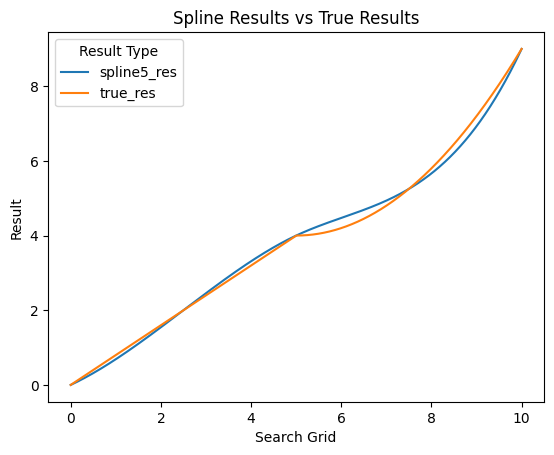

In [23]:
n = 5
spline_res1 = create_spline(n)

print(f"RMSE: {get_spline_rmse(spline_res1, n)}")
get_spline_plot(spline_res1, n)

### b) Spline - n = 10

We can follow the same procedure

RMSE: -0.004347076553643021


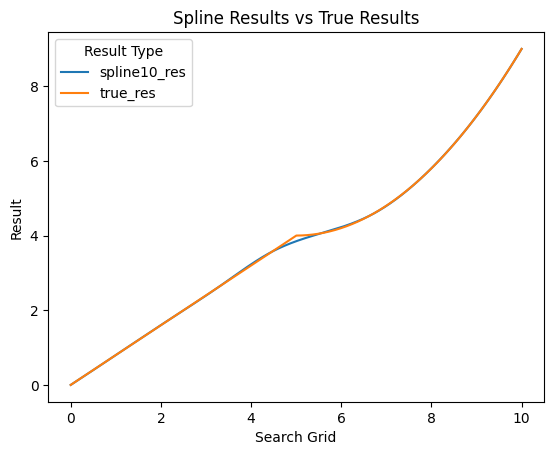

In [24]:
n = 10
spline_res1 = create_spline(n)

print(f"RMSE: {get_spline_rmse(spline_res1, n)}")
get_spline_plot(spline_res1, n)

We can see that the RMSE indeed decreased, as we have more points to do a more precise spline interpolation. Specially, we identify better the break in the consumption function, as there are points closer to it, in comparison to before.

### c) Robustness Check

We can run the spline results across different values of $n$.

[Text(0.5, 0, 'Nodes'), Text(0, 0.5, 'RMSE'), Text(0.5, 1.0, 'RMSE vs Nodes')]

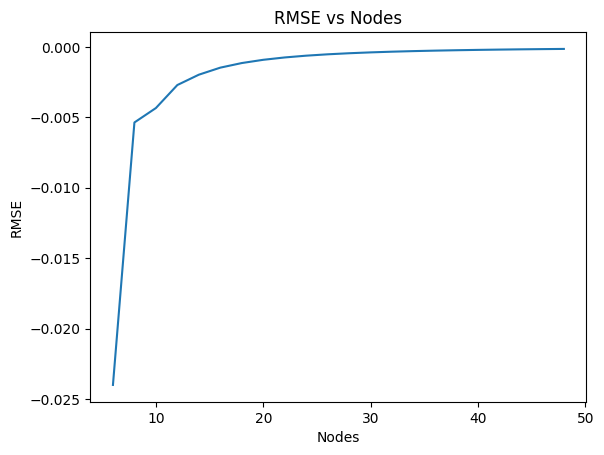

In [25]:
q4_options = np.arange(6, 50, 2)

rmse_data = pl.DataFrame({
    'rmse': [get_spline_rmse(create_spline(n), n) for n in q4_options],
    'n': q4_options
})

g = sns.lineplot(data=rmse_data, x='n', y='rmse')
g.set(xlabel='Nodes', ylabel='RMSE', title='RMSE vs Nodes')


We can see that the RMSE quickly decreases as we increase the number of points. This is expected, as the spline function is able to better approximate the consumption function.

### c) Optimal Nodes

From the graph of the last answer, we can see that 7 nodes yields a great RMSE, without imposing too much computational cost.